In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep

import pickle as pkl
import sys
sys.path.insert(0,'..')
from models import ParticleNet
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.data import Data, Batch

import networkx as nx
from networkx import draw_networkx_nodes, draw_networkx_edges

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})

import awkward as ak
import fastjet
import vector

## Configuration

In [5]:
if torch.cuda.device_count():
    device = torch.device("cuda:0")
else:
    device = "cpu"
    
N_SUBJETS = 3

LABEL = {}
LABEL[fastjet.kt_algorithm] = "$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.antikt_algorithm] = "anti-$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.cambridge_algorithm] = "CA"

# JET_ALGO = fastjet.kt_algorithm
# JET_ALGO = fastjet.antikt_algorithm
JET_ALGO = fastjet.cambridge_algorithm

jetdef = fastjet.JetDefinition(JET_ALGO, 0.8)

In [6]:
def get_subjets(px, py, pz, e):
    vector.register_awkward()
    px = ak.from_regular(ak.from_numpy(px.numpy()))
    py = ak.from_regular(ak.from_numpy(py.numpy()))
    pz = ak.from_regular(ak.from_numpy(pz.numpy()))
    e = ak.from_regular(ak.from_numpy(e.numpy()))

    # define jet directly not an array of jets
    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
            "particle_idx": ak.local_index(px),
            "subjet_idx": ak.zeros_like(px, dtype=int) - 1,
        },
        with_name="Momentum4D",
    )

    pseudojets = []
    pseudojets.append(
        [
            fastjet.PseudoJet(particle.px, particle.py, particle.pz, particle.E)
            for particle in jet
        ]
    )

    subjet_indices = []
    mapping = [jet.subjet_idx.to_list()]   # added square brackets
    for ijet, pseudojet in enumerate(pseudojets):
        subjet_indices.append([])
        cluster = fastjet.ClusterSequence(pseudojet, jetdef)

        # cluster jets
        jets = cluster.inclusive_jets()
        assert len(jets) == 1

        # get the 3 exclusive jets
        subjets = cluster.exclusive_subjets(jets[0], N_SUBJETS)
        assert len(subjets) == N_SUBJETS

        # sort by pt
        subjets = sorted(subjets, key=lambda x: x.pt(), reverse=True)

        for subjet_idx, subjet in enumerate(subjets):
            subjet_indices[-1].append([])
            for subjet_const in subjet.constituents():
                for idx, jet_const in enumerate(pseudojet):
                    if (
                        subjet_const.px() == jet_const.px()
                        and subjet_const.py() == jet_const.py()
                        and subjet_const.pz() == jet_const.pz()
                        and subjet_const.E() == jet_const.E()
                    ):
                        subjet_indices[-1][-1].append(idx)

        for subjet_idx, subjet in enumerate(subjets):
            local_mapping = np.array(mapping[ijet])
            local_mapping[subjet_indices[ijet][subjet_idx]] = subjet_idx
            mapping[ijet] = local_mapping

    # update array
    # array.subjet_idx = ak.Array(mapping)
    jet = ak.zip(
        {
            "px": px,
            "py": py,
            "pz": pz,
            "E": e,
            "particle_idx": ak.local_index(px),
            "subjet_idx": ak.Array(mapping[0]), # pick first element
        },
        with_name="Momentum4D",
    )    

    jet_vector = vector.obj(
        px=ak.sum(jet.px, axis=-1),
        py=ak.sum(jet.py, axis=-1),
        pz=ak.sum(jet.pz, axis=-1),
        E=ak.sum(jet.E, axis=-1),
    )
    subjet_vectors = [
        vector.obj(
            px=ak.sum(jet.px[jet.subjet_idx == j], axis=-1),
            py=ak.sum(jet.py[jet.subjet_idx == j], axis=-1),
            pz=ak.sum(jet.pz[jet.subjet_idx == j], axis=-1),
            E=ak.sum(jet.E[jet.subjet_idx == j], axis=-1),
        )
        for j in range(0, N_SUBJETS)
    ]

    deta = jet.deltaeta(jet_vector)
    dphi = jet.deltaphi(jet_vector)
    dpt = jet.pt / jet_vector.pt
    
    subjet_idx = jet.subjet_idx.to_numpy()
    
    return subjet_idx, subjet_vectors, deta, dphi, dpt

# Load Rscores

In [84]:
PATH = '/xai4hepvol/ParticleNet_6/Rscores_best'

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)
    
with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
    batch_px_list = pkl.load(handle)
with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
    batch_py_list = pkl.load(handle)  
with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
    batch_pz_list = pkl.load(handle)
with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
    batch_E_list = pkl.load(handle)     

## No edges

27 [8, 15, 13]
Building the graph...
Plotting the point cloud...


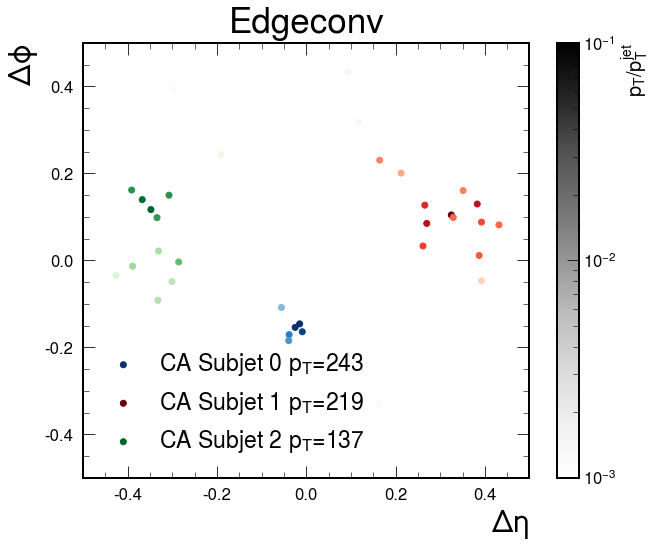

In [111]:
Num_jets = len(batch_px_list)
for i in range(Num_jets):
#     if i not in [16,21,39,78]:
#         continue
    if i != 27:
        continue        
    jet_label = batch_y_list[i]
    
    if jet_label!=1: # pick Tops for plotting
        continue
    
    jet_input = batch_x_list[i]
        
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    print(i, [(subjet_idx==0).sum(), (subjet_idx==1).sum(), (subjet_idx==2).sum()])
    
#     # testing the score
#     print('Testing a forward pass...')        
#     sig = nn.Sigmoid()
#     model_score = round(sig(model(Batch(x=jet_input, batch=torch.zeros(len(jet_input), dtype=int)))[0]).item(),3)            

    print('Building the graph...')        
    eta = torch.tensor(eta).reshape(-1,1)
    phi = torch.tensor(phi).reshape(-1,1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # Get positions of nodes in the graph
    pos = {}
    num_nodes = len(px)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # subjet node colors
    COLOR_from_idx = ['Blues', 'Reds', 'Greens', 'Oranges', 'Yellows', 'Purples']

    Num_subjets = len(np.unique(subjet_idx))
    COLOR_from_idx = COLOR_from_idx[:Num_subjets] 
    
    # plot nodes without connections
    print(f'Plotting the point cloud...')        
    fig, ax = plt.subplots(figsize=(10, 8))            
    for j in range(Num_subjets):
        ax.scatter(
            eta[subjet_idx == j],
            phi[subjet_idx == j],
            c=pt[subjet_idx == j],
            cmap=COLOR_from_idx[j],
            norm=colors.LogNorm(vmin=0.001, vmax=0.1),
            label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",
        )      

    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")
    ax.legend()    

    plt.xlabel(r"$\Delta\eta$", fontsize=30) 
    plt.ylabel(r"$\Delta\phi$", fontsize=30) 
    
    plt.ylim(-0.5, 0.5)
    plt.xlim(-0.5, 0.5)
    ax.set_xticks([-0.4,-0.2,0,0.2,0.4])
    ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
#     plt.ylim(-1.2, 1.2)
#     plt.xlim(-1.2, 1.2)    
#     ax.set_xticks([-1,-0.5,0,0.5,1])
#     ax.set_yticks([-1,-0.5,0,0.5,1])    
    ax.tick_params(pad=10, left=True, bottom=True, labelleft=True, labelbottom=True)    
#     plt.legend(title="Top jet" if jet_label==1 else "QCD jet", title_fontsize=40, fontsize=20)
    plt.legend(fontsize=23)    
#     plt.savefig(f"/xai4hepvol/paper/jet.pdf")    
    plt.show() 
#     break

## Edges

27 [8, 15, 13]
Building the graph...
Plotting the Edge-Rgraph for edge_conv_0...


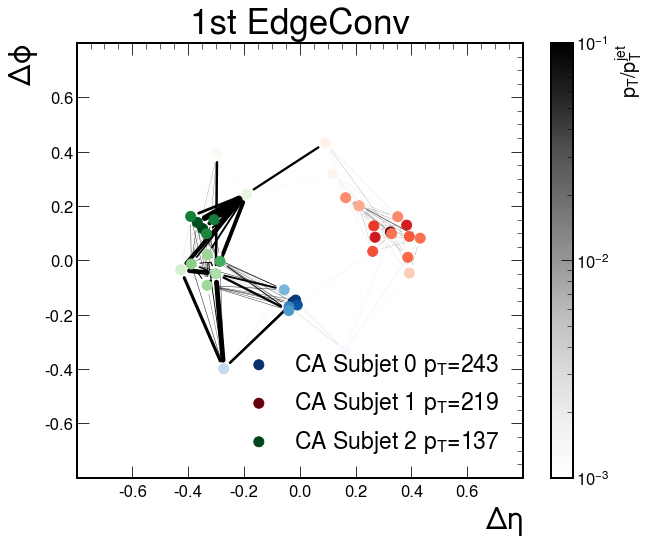

Plotting the Edge-Rgraph for edge_conv_1...


/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


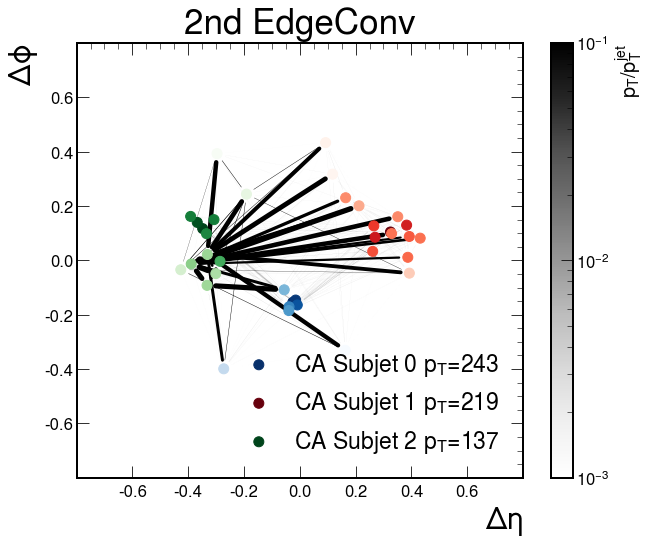

Plotting the Edge-Rgraph for edge_conv_2...


/tmp/ipykernel_686/3705636054.py:105: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"/xai4hepvol/paper/{edgeconv}.png")
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


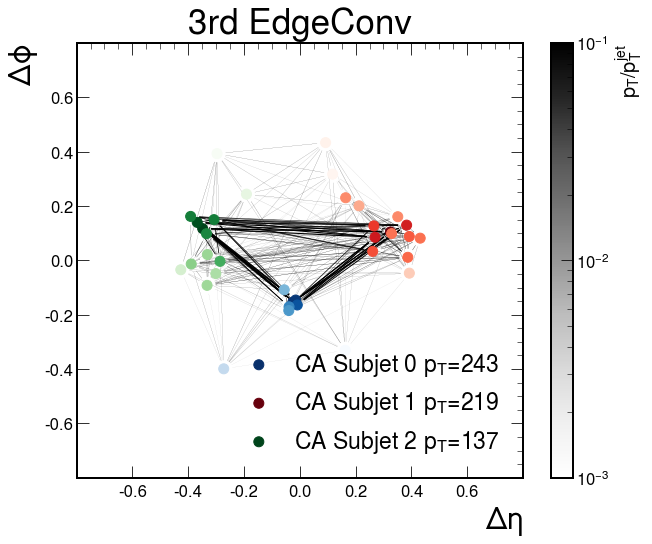

In [115]:
dic = {}
dic['edge_conv_0'] = '1st EdgeConv'
dic['edge_conv_1'] = '2nd EdgeConv'
dic['edge_conv_2'] = '3rd EdgeConv'

Num_jets = len(batch_px_list)
for i in range(Num_jets):
#     if i not in [21]:
#         continue
    if i != 27:
        continue        
    jet_label = batch_y_list[i]
    
    if jet_label!=1: # pick Tops for plotting
        continue
    
    jet_input = batch_x_list[i]
        
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    print(i, [(subjet_idx==0).sum(), (subjet_idx==1).sum(), (subjet_idx==2).sum()])
    
#     # testing the score
#     print('Testing a forward pass...')        
#     sig = nn.Sigmoid()
#     model_score = round(sig(model(Batch(x=jet_input, batch=torch.zeros(len(jet_input), dtype=int)))[0]).item(),3)            

    print('Building the graph...')        
    eta = torch.tensor(eta).reshape(-1,1)
    phi = torch.tensor(phi).reshape(-1,1)
    eta_phi = torch.cat([eta, phi], axis=1)

    # Get positions of nodes in the graph
    pos = {}
    num_nodes = len(px)
    for node_i in range(num_nodes):
        pos[node_i] = eta_phi.numpy()[node_i]

    # subjet node colors
    COLOR_from_idx = ['Blues', 'Reds', 'Greens', 'Oranges', 'Yellows', 'Purples']

    Num_subjets = len(np.unique(subjet_idx))
    COLOR_from_idx = COLOR_from_idx[:Num_subjets]   
            
    # plot edgeconv blocks
    for edgeconv in ['edge_conv_0', 'edge_conv_1', 'edge_conv_2']:    
#     for edgeconv in ['edge_conv_2']:    

        edge_index, edge_weight = edge_index_dic[edgeconv], torch.abs(R_edges[edgeconv]).sum(axis=1)
        edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

        data = torch_geometric.data.Data(edge_index=edge_index, edge_weight=edge_weight, num_nodes=num_nodes)
        G = torch_geometric.utils.to_networkx(data, to_undirected=False)

        print(f'Plotting the Edge-Rgraph for {edgeconv}...')        
        fig, ax = plt.subplots(figsize=(10, 8))
        for j in range(Num_subjets):
            
            draw_networkx_nodes(G, pos, 
                                nodelist=np.array(list(G))[subjet_idx==j].tolist(), 
                                node_color=np.log(pt[subjet_idx==j]),
                                node_size=100,
                                cmap=COLOR_from_idx[j], 
                                ax=ax, 
                                label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",                        
                               )
        plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
        cbar = plt.colorbar()
        cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")

        draw_networkx_edges(G, pos, 
                            width=100*(edge_Rscores),
                            edge_color='k', 
                            style='solid', 
                            arrowsize=10,
                            ax=ax, 
                            arrowstyle='-'
                           )

        ax.legend()    
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

        plt.xlabel(r"$\Delta\eta$", fontsize=30) 
        plt.ylabel(r"$\Delta\phi$", fontsize=30) 
        
        plt.ylim(-0.8, 0.8)
        plt.xlim(-0.8, 0.8)
        ax.set_xticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
        ax.set_yticks([-0.6, -0.4,-0.2,0,0.2,0.4, 0.6])
    #     plt.ylim(-1.2, 1.2)
    #     plt.xlim(-1.2, 1.2)    
    #     ax.set_xticks([-1,-0.5,0,0.5,1])
    #     ax.set_yticks([-1,-0.5,0,0.5,1])  
    #     plt.legend(title="Top jet" if jet_label==1 else "QCD jet")        
        plt.legend(fontsize=23)    
        ax.set_title(f"{dic[edgeconv]}", pad=10, fontsize=35) 
        plt.savefig(f"/xai4hepvol/paper/{edgeconv}.pdf")
        plt.show()        
#         break
#     break

## Scaling up

In [9]:
# best epoch
from tqdm.notebook import tqdm

Top_N = 15

top_same = np.array([0] * Top_N)
top_diff = np.array([0] * Top_N)
qcd_same = np.array([0] * Top_N)
qcd_diff = np.array([0] * Top_N)

PATH = '/xai4hepvol/ParticleNet_6/best_epoch'

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)
    
with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
    batch_px_list = pkl.load(handle)
with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
    batch_py_list = pkl.load(handle)  
with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
    batch_pz_list = pkl.load(handle)
with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
    batch_E_list = pkl.load(handle)  

Num_jets = len(batch_px_list)
for i in tqdm(range(Num_jets)):
    jet_label = batch_y_list[i]

    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]

    # get subjets
    try:
        subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    except:
        print(f"skipping jet # {i}")
        continue

    # top N edges
    edge_index, edge_weight = edge_index_dic, torch.abs(R_edges).sum(axis=1)
    edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

    for N in range(Top_N):
        for edge in torch.topk(edge_Rscores, N+1).indices:   # N=0 doesn't make sense here
            if jet_label==1:
                if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:
                    top_diff[N] += 1
                else:
                    top_same[N] += 1
            else:
                if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:      
                    qcd_diff[N] += 1
                else:
                    qcd_same[N] += 1

  0%|          | 0/996 [00:00<?, ?it/s]

#--------------------------------------------------------------------------
#                         FastJet release 3.3.4
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
skipping jet # 25
skipping jet # 537


In [12]:
top_fraction = top_diff/(top_same+top_diff)
qcd_fraction = qcd_diff/(qcd_same+qcd_diff)

import pickle as pkl

with open('/xai4hepvol/trained_top_fraction.pkl', 'wb') as f:
    pkl.dump(top_fraction, f)
with open('/xai4hepvol/trained_qcd_fraction.pkl', 'wb') as f:
    pkl.dump(qcd_fraction, f)  

Text(0, 1, 'Fraction of edges connecting different subjets')

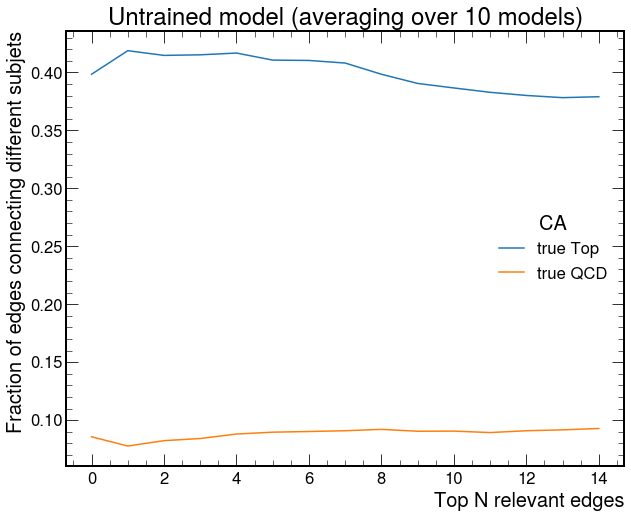

In [116]:
with open('/xai4hepvol/trained_top_fraction.pkl', 'rb') as f:
    trained_top_fraction = pkl.load(f) 
with open('/xai4hepvol/trained_qcd_fraction.pkl', 'rb') as f:
    trained_qcd_fraction = pkl.load(f) 
    
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(len(trained_top_fraction)), trained_top_fraction, label='true Top')
ax.plot(range(len(trained_qcd_fraction)), trained_qcd_fraction, label='true QCD')

plt.legend(title=f"{LABEL[JET_ALGO]}")
ax.set_title('Untrained model (averaging over 10 models)')
ax.set_xlabel(r"Top N relevant edges")
ax.set_ylabel(r"Fraction of edges connecting different subjets")

In [16]:
# before training
from tqdm.notebook import tqdm

Top_N = 15

top_same = np.array([0] * Top_N)
top_diff = np.array([0] * Top_N)
qcd_same = np.array([0] * Top_N)
qcd_diff = np.array([0] * Top_N)

for model in range(10):
    print(f'model # {model}')
    PATH = f'/xai4hepvol/ParticleNet_6/Rscores_{model}'

    import networkx as nx
    import torch
    import torch_geometric
    import numpy as np
    import pickle as pkl

    with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
        batch_x_list = pkl.load(handle)
    with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
        batch_y_list = pkl.load(handle)    
    with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
        R_edges_list = pkl.load(handle)    
    with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
        edge_index_list = pkl.load(handle)

    with open(f'{PATH}/batch_px.pkl', 'rb') as handle:
        batch_px_list = pkl.load(handle)
    with open(f'{PATH}/batch_py.pkl', 'rb') as handle:
        batch_py_list = pkl.load(handle)  
    with open(f'{PATH}/batch_pz.pkl', 'rb') as handle:
        batch_pz_list = pkl.load(handle)
    with open(f'{PATH}/batch_E.pkl', 'rb') as handle:
        batch_E_list = pkl.load(handle) 

    Num_jets = len(batch_px_list)
    for i in tqdm(range(Num_jets)):
        jet_label = batch_y_list[i]

        R_edges = R_edges_list[i]
        edge_index_dic = edge_index_list[i]

        px = batch_px_list[i]
        py = batch_py_list[i]
        pz = batch_pz_list[i]
        e = batch_E_list[i]

        # get subjets
        try:
            subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
        except:
            print(f"skipping jet # {i}")
            continue

        # top N edges
        edge_index, edge_weight = edge_index_dic, torch.abs(R_edges).sum(axis=1)
        edge_Rscores = edge_weight/sum(edge_weight)  # normalize sum of Rscores of all jets to be 1

        for N in range(Top_N):
            for edge in torch.topk(edge_Rscores, N+1).indices:   # N=0 doesn't make sense here
                if jet_label==1:
                    if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:
                        top_diff[N] += 1
                    else:
                        top_same[N] += 1
                else:
                    if subjet_idx[edge_index[0][edge]]!=subjet_idx[edge_index[1][edge]]:      
                        qcd_diff[N] += 1
                    else:
                        qcd_same[N] += 1

model # 0


  0%|          | 0/989 [00:00<?, ?it/s]

skipping jet # 81
skipping jet # 164
skipping jet # 508
model # 1


  0%|          | 0/995 [00:00<?, ?it/s]

skipping jet # 533
model # 2


  0%|          | 0/999 [00:00<?, ?it/s]

skipping jet # 49
skipping jet # 474
skipping jet # 714
model # 3


  0%|          | 0/997 [00:00<?, ?it/s]

skipping jet # 24
skipping jet # 387
skipping jet # 511
skipping jet # 719
skipping jet # 926
model # 4


  0%|          | 0/995 [00:00<?, ?it/s]

skipping jet # 924
model # 5


  0%|          | 0/995 [00:00<?, ?it/s]

skipping jet # 742
model # 6


  0%|          | 0/998 [00:00<?, ?it/s]

skipping jet # 963
model # 7


  0%|          | 0/995 [00:00<?, ?it/s]

skipping jet # 216
model # 8


  0%|          | 0/997 [00:00<?, ?it/s]

skipping jet # 222
skipping jet # 667
model # 9


  0%|          | 0/992 [00:00<?, ?it/s]

skipping jet # 752


In [17]:
top_fraction = top_diff/(top_same+top_diff)
qcd_fraction = qcd_diff/(qcd_same+qcd_diff)

import pickle as pkl

with open('/xai4hepvol/untrained_top_fraction.pkl', 'wb') as f:
    pkl.dump(top_fraction, f)
with open('/xai4hepvol/untrained_qcd_fraction.pkl', 'wb') as f:
    pkl.dump(qcd_fraction, f)  

Text(0, 1, 'Fraction of edges connecting different subjets')

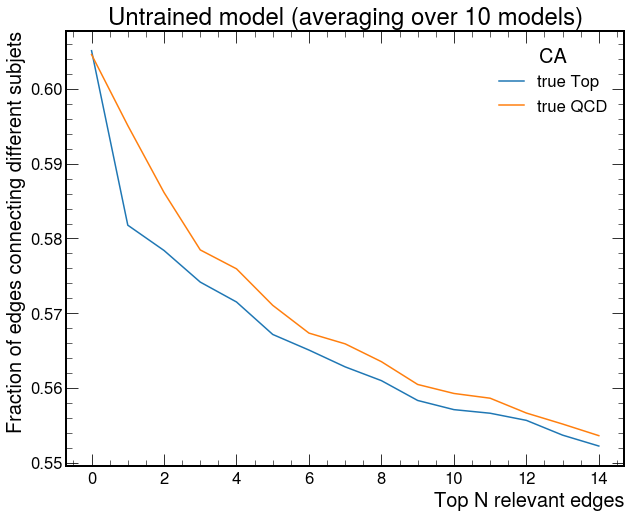

In [117]:
with open('/xai4hepvol/untrained_top_fraction.pkl', 'rb') as f:
    untrained_top_fraction = pkl.load(f) 
with open('/xai4hepvol/untrained_qcd_fraction.pkl', 'rb') as f:
    untrained_qcd_fraction = pkl.load(f) 
    
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(range(len(untrained_top_fraction)), untrained_top_fraction, label='true Top')
ax.plot(range(len(untrained_qcd_fraction)), untrained_qcd_fraction, label='true QCD')

plt.legend(title=f"{LABEL[JET_ALGO]}")
ax.set_title('Untrained model (averaging over 10 models)')
ax.set_xlabel(r"Top N relevant edges")
ax.set_ylabel(r"Fraction of edges connecting different subjets")

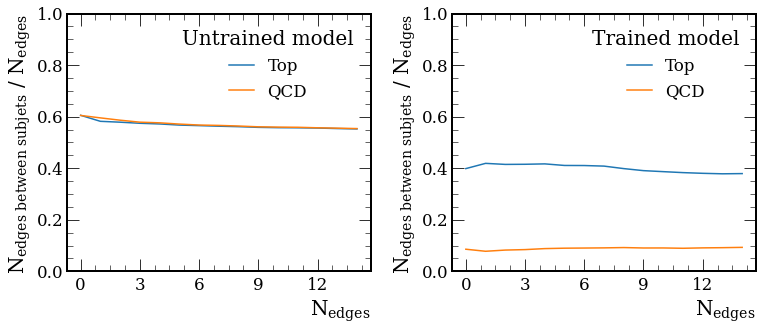

In [208]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
# font.set_family('serif')
font.set_name('Times New Roman')
# plt.rcParams.update({'font.family':'sans-serif'}) 
plt.rcParams.update({'font.family':'serif'}) 

# make the plot
fig, axes = plt.subplots(ncols=2, figsize=(11,5))
axes[0].plot(range(len(untrained_top_fraction)), untrained_top_fraction, label='Top')
axes[0].plot(range(len(untrained_qcd_fraction)), untrained_qcd_fraction, label='QCD')
axes[0].legend(title='Untrained model')
# axes[0].set_yscale('log') 
axes[0].set_ylim(0,1)
axes[0].set_xlabel(r'$N_{edges}$', fontsize=20)
axes[0].set_xticks(range(0, 15, 3))
axes[0].set_ylabel(r'$N_{edges \ between \ subjets}$ / $N_{edges}$', fontsize=20)

axes[1].plot(range(len(trained_top_fraction)), trained_top_fraction, label='Top')
axes[1].plot(range(len(trained_qcd_fraction)), trained_qcd_fraction, label='QCD')
axes[1].legend(title='Trained model')
# axes[1].set_yscale('log') 
axes[1].set_ylim(0,1)
axes[1].set_xlabel(r'$N_{edges}$', fontsize=20)
axes[1].set_xticks(range(0, 15, 3))
axes[1].set_ylabel(r'$N_{edges \ between \ subjets}$ / $N_{edges}$', fontsize=20)

# plt.subplots_adjust(wspace=4)

fig.tight_layout()

plt.savefig('/xai4hepvol/paper/scaling_up.pdf')
plt.show()

In [ ]:
from tqdm.notebook import tqdm

top = [0] * 3
qcd = [0] * 3

Num_jets = len(batch_px_list)
for i in tqdm(range(Num_jets)):
    jet_label = batch_y_list[i]
    
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    try:
        subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    except:
        print(f"skipping jet # {i}")
        continue
  
    if jet_label==1:
        top[0] += (subjet_idx == 0).sum()
        top[1] += (subjet_idx == 1).sum()
        top[2] += (subjet_idx == 2).sum()
    else:
        qcd[0] += (subjet_idx == 0).sum()
        qcd[1] += (subjet_idx == 1).sum()
        qcd[2] += (subjet_idx == 2).sum()        
    top = np.array(top)
    qcd = np.array(qcd)
#     if i==100:
#         break

In [26]:
from tqdm.notebook import tqdm

top = np.array([0] * 3)
qcd = np.array([0] * 3)
    
Num_jets = len(batch_px_list)
for i in tqdm(range(Num_jets)):
    jet_label = batch_y_list[i]
    
    R_edges = R_edges_list[i]
    edge_index_dic = edge_index_list[i]

    px = batch_px_list[i]
    py = batch_py_list[i]
    pz = batch_pz_list[i]
    e = batch_E_list[i]
    
    # get subjets
    try:
        subjet_idx, subjet_vectors, eta, phi, pt = get_subjets(px, py, pz, e)
    except:
        print(f"skipping jet # {i}")
        continue
  
    if jet_label==1:
        top[0] += (subjet_idx == 0).sum()
        top[1] += (subjet_idx == 1).sum()
        top[2] += (subjet_idx == 2).sum()
    else:
        qcd[0] += (subjet_idx == 0).sum()
        qcd[1] += (subjet_idx == 1).sum()
        qcd[2] += (subjet_idx == 2).sum()        

#     if i==100:
#         break

  0%|          | 0/996 [00:00<?, ?it/s]

skipping jet # 25
skipping jet # 537


In [38]:
[0.1,0.2,0.3]

range(0, 3)

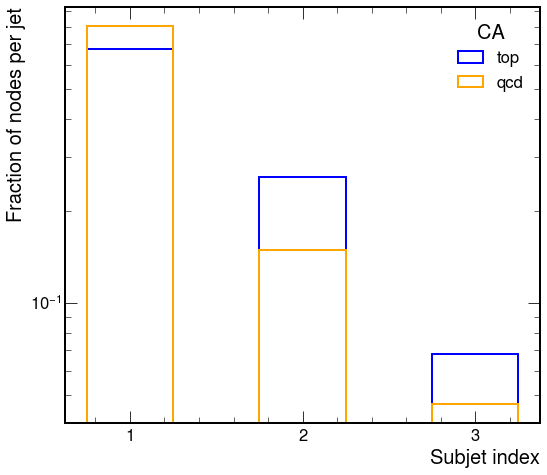

In [76]:
fig, ax = plt.subplots(figsize=(8, 7))
ax.bar([0.2,0.3,0.4], top/top.sum(), width=0.05, linewidth=2, edgecolor='Blue', fill=False, align='center', label='top', tick_label=[1,2,3])
ax.bar([0.2,0.3,0.4], qcd/qcd.sum(), width=0.05, linewidth=2, edgecolor='Orange', fill=False, align='center', label='qcd', tick_label=[1,2,3])

ax.legend()

plt.legend(title=f"{LABEL[JET_ALGO]}")
    
ax.set_yscale('log')
ax.set_xlabel(r"Subjet index")
ax.set_ylabel(r"Fraction of nodes per jet")
plt.tight_layout()
plt.savefig(f"/xai4hepvol/CA_bar.pdf")

## LRP

In [48]:
PATH = '/xai4hepvol/ParticleNet_6/before_training'

import networkx as nx
import torch
import torch_geometric
import numpy as np
import pickle as pkl

with open(f'{PATH}/batch_x.pkl', 'rb') as handle:
    batch_x_list = pkl.load(handle)
with open(f'{PATH}/batch_y.pkl', 'rb') as handle:
    batch_y_list = pkl.load(handle)    
with open(f'{PATH}/Rscores.pkl', 'rb') as handle:
    Rscores_list = pkl.load(handle)
with open(f'{PATH}/R_edges.pkl', 'rb') as handle:
    R_edges_list = pkl.load(handle)    
with open(f'{PATH}/edge_index.pkl', 'rb') as handle:
    edge_index_list = pkl.load(handle)

## Javier

df['is_signal_new'].values=array([1, 1])
len(pseudojets)=2
len(pseudojets[0])=55
len(jets)=1
len(subjets)=3
[45, 23, 43, 22, 46, 25, 53, 9, 38, 8, 2, 29, 6, 12, 13, 28, 42, 18, 41, 5, 3, 10, 4, 24, 33, 48, 49, 50, 54]
[31, 44, 32, 51, 27, 15, 21, 47, 30, 39, 0, 7, 11, 14, 16]
[20, 36, 17, 35, 40, 52, 1, 19, 37, 26, 34]
len(jets)=1
len(subjets)=3
[35, 2, 40, 15, 46, 59, 7, 14, 6, 24, 26, 29, 21, 3, 4, 31, 1, 45]
[0, 39, 58, 27, 61, 13, 18, 23, 11, 22, 5, 34, 44, 16, 56, 32, 9, 43]
[25, 33, 8, 20, 49, 50, 17, 57, 10, 19, 12, 38, 54, 47, 52, 41, 60, 53, 42, 36, 51, 37, 30, 55, 28, 48]


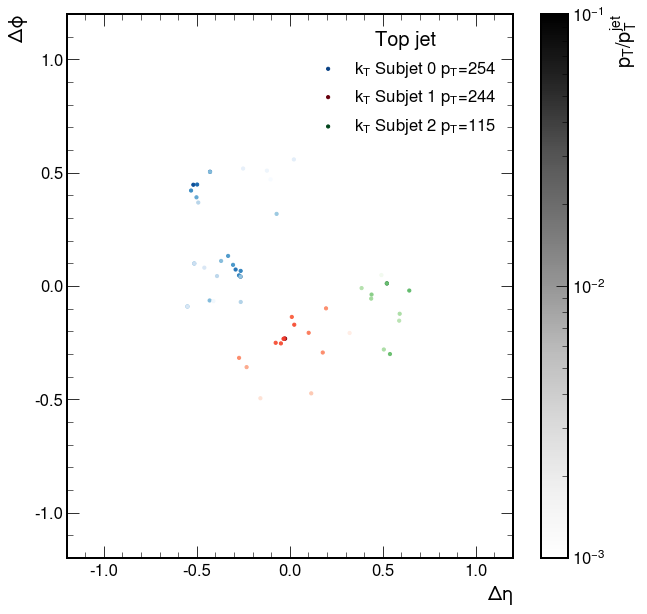

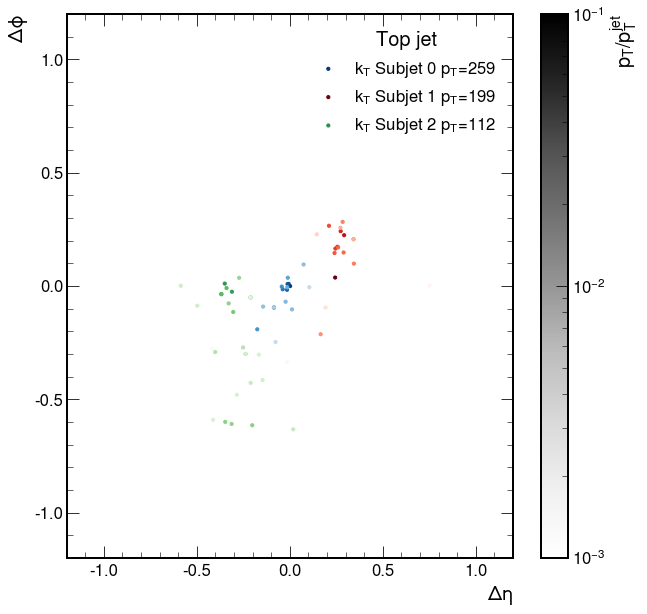

In [37]:
import awkward as ak
import fastjet
import vector
import pandas as pd
import numpy as np

N_SUBJETS = 3

LABEL = {}
LABEL[fastjet.kt_algorithm] = "$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.antikt_algorithm] = "anti-$k_{{\mathrm{{T}}}}$"
LABEL[fastjet.cambridge_algorithm] = "CA"

JET_ALGO = fastjet.kt_algorithm

df = pd.read_hdf("/xai4hepvol/toptagging/test/raw/test.h5", key="table", start=1000, stop=1002)
print(f"{df['is_signal_new'].values=}")


def _col_list(prefix, max_particles=200):
    return ["%s_%d" % (prefix, i) for i in range(max_particles)]


vector.register_awkward()
px = ak.from_regular(ak.from_numpy(df[_col_list("PX")].values), axis=-1)
py = ak.from_regular(ak.from_numpy(df[_col_list("PY")].values), axis=-1)
pz = ak.from_regular(ak.from_numpy(df[_col_list("PZ")].values), axis=-1)
e = ak.from_regular(ak.from_numpy(df[_col_list("E")].values), axis=-1)
mask = e > 0

array = ak.zip(
    {
        "px": px[mask],
        "py": py[mask],
        "pz": pz[mask],
        "E": e[mask],
        "mask": mask[mask],
        "particle_idx": ak.local_index(px[mask]),
        "subjet_idx": ak.zeros_like(px[mask], dtype=int) - 1,
    },
    with_name="Momentum4D",
)

pseudojets = []
for jet in array:
    pseudojets.append(
        [
            fastjet.PseudoJet(particle.px, particle.py, particle.pz, particle.E)
            for particle in jet
        ]
    )
print(f"{len(pseudojets)=}")
print(f"{len(pseudojets[0])=}")


jetdef = fastjet.JetDefinition(JET_ALGO, 0.8)

subjet_indices = []
mapping = array.subjet_idx.to_list()
for ijet, pseudojet in enumerate(pseudojets):
    subjet_indices.append([])
    cluster = fastjet.ClusterSequence(pseudojet, jetdef)

    # cluster jets
    jets = cluster.inclusive_jets()
    print(f"{len(jets)=}")
    assert len(jets) == 1

    # get the 3 exclusive jets
    subjets = cluster.exclusive_subjets(jets[0], N_SUBJETS)
    print(f"{len(subjets)=}")
    assert len(subjets) == N_SUBJETS

    # sort by pt
    subjets = sorted(subjets, key=lambda x: x.pt(), reverse=True)

    for subjet_idx, subjet in enumerate(subjets):
        subjet_indices[-1].append([])
        for subjet_const in subjet.constituents():
            for idx, jet_const in enumerate(pseudojet):
                if (
                    subjet_const.px() == jet_const.px()
                    and subjet_const.py() == jet_const.py()
                    and subjet_const.pz() == jet_const.pz()
                    and subjet_const.E() == jet_const.E()
                ):
                    subjet_indices[-1][-1].append(idx)

    for subjet_idx, subjet in enumerate(subjets):
        print(subjet_indices[ijet][subjet_idx])
        local_mapping = np.array(mapping[ijet])
        local_mapping[subjet_indices[ijet][subjet_idx]] = subjet_idx
        mapping[ijet] = local_mapping

# update array
# array.subjet_idx = ak.Array(mapping)
array = ak.zip(
    {
        "px": px[mask],
        "py": py[mask],
        "pz": pz[mask],
        "E": e[mask],
        "mask": mask[mask],
        "particle_idx": ak.local_index(px[mask]),
        "subjet_idx": ak.Array(mapping),
    },
    with_name="Momentum4D",
)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

for i, arr in enumerate(array):
    fig = plt.figure()
    jet_vector = vector.obj(
        px=ak.sum(arr.px, axis=-1),
        py=ak.sum(arr.py, axis=-1),
        pz=ak.sum(arr.pz, axis=-1),
        E=ak.sum(arr.E, axis=-1),
    )
    subjet_vectors = [
        vector.obj(
            px=ak.sum(arr.px[arr.subjet_idx == j], axis=-1),
            py=ak.sum(arr.py[arr.subjet_idx == j], axis=-1),
            pz=ak.sum(arr.pz[arr.subjet_idx == j], axis=-1),
            E=ak.sum(arr.E[arr.subjet_idx == j], axis=-1),
        )
        for j in range(0, N_SUBJETS)
    ]

    deta = arr.deltaeta(jet_vector)
    dphi = arr.deltaphi(jet_vector)
    dpt = arr.pt / jet_vector.pt

    for j, cmap in zip(range(0, N_SUBJETS), ["Blues", "Reds", "Greens", "Purples"]):
        plt.scatter(
            deta[arr.subjet_idx == j],
            dphi[arr.subjet_idx == j],
            c=dpt[arr.subjet_idx == j],
            s=10,
            norm=colors.LogNorm(vmin=0.001, vmax=0.1),
            cmap=cmap,
            label=f"{LABEL[JET_ALGO]} Subjet {j} $p_{{\mathrm{{T}}}}$={subjet_vectors[j].pt:.0f}",
        )
    plt.scatter([], [], c=[], cmap="Greys", norm=colors.LogNorm(vmin=0.001, vmax=0.1))
    cbar = plt.colorbar()
    cbar.set_label("$p_{\mathrm{T}} / p_{\mathrm{T}}^{\mathrm{jet}}$")
    plt.xlabel(r"$\Delta\eta$")
    plt.ylabel(r"$\Delta\phi$")
    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    plt.legend(title="Top jet" if df["is_signal_new"].values[i] == 1 else "QCD jet")
    plt.savefig(f"etaphi_{i}.pdf")
    plt.savefig(f"etaphi_{i}.png")